In [1]:
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import tqdm
import time
import os
import wandb
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from collections import OrderedDict
from external_utils import format_time
from utils.data_preprocessing import preprocess_dataset_get_dataset, generate_dataset_from_loader,preprocess_dataset_get_data_loader,get_data_loader
from structure.dlgn_conv_config_structure import DatasetConfig
import numpy as np
import csv
from conv4_models import get_model_instance_from_dataset, get_img_size
from utils.forward_visualization_helpers import merge_operations_in_modules, apply_input_on_conv_matrix, merge_layers_operations_in_modules
from sklearn import datasets, metrics, svm
from tqdm import trange
import pickle
from structure.generic_structure import SaveFeatures
from matplotlib import colors
from sklearn.decomposition import PCA

Using TensorFlow backend.
2024-06-24 18:12:30.304911: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2024-06-24 18:12:30.305048: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2024-06-24 18:12:30.305059: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
model_arch_type = 'dnn'
dataset = 'mnist'
data_config = DatasetConfig(
                dataset, is_normalize_data=True, valid_split_size=0.1, batch_size=128, list_of_classes=None,custom_dataset_path=None)

filtered_X_train, filtered_y_train, _, _, filtered_X_test, filtered_y_test = preprocess_dataset_get_dataset(
            data_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)
print("filtered_X_train ",np.max(filtered_X_train),np.min(filtered_X_train))
print("filtered_X_test ",np.max(filtered_X_test),np.min(filtered_X_test))
trainloader = get_data_loader(
    filtered_X_train, filtered_y_train, data_config.batch_size, transforms=data_config.train_transforms)
testloader = get_data_loader(
    filtered_X_test, filtered_y_test, data_config.batch_size, transforms=data_config.test_transforms)

# trainloader, _, testloader = preprocess_dataset_get_data_loader(
#                 data_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)

np.max(filtered_X_train) 255.0
filtered_X_train  1.0 0.0
filtered_X_test  1.0 0.0


In [4]:
tst = next(iter(trainloader))
tst[0].size()

torch.Size([128, 1, 28, 28])

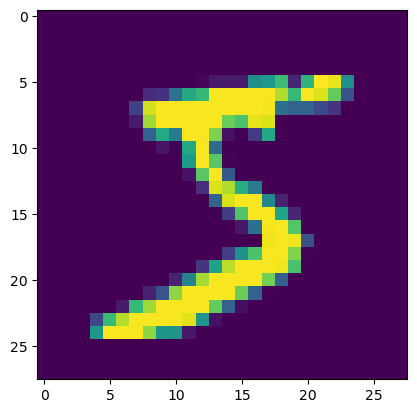

In [5]:
img = tst[0][0]
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [6]:
def get_pca_object(data, explained_var_required):
    if(isinstance(data, torch.Tensor)):
        flattened_data = torch.flatten(data, 1)
    elif(isinstance(data, list)):
        flattened_data = np.stack(data)
        flattened_data = flattened_data.reshape(
            flattened_data.shape[0], np.prod(flattened_data.shape[1:]))
    else:
        flattened_data = data.reshape(
            data.shape[0], data.shape[1]*data.shape[2])
    pca = PCA().fit(flattened_data)
    k = 0
    current_variance = 0
    while(current_variance < explained_var_required):
        current_variance = sum(pca.explained_variance_ratio_[:k])
        k = k + 1

    print("Number of PCA components used is:", k)
    k_pca = PCA(n_components=k)
    k_pca.fit(flattened_data)
    return k_pca

In [7]:
filtered_X_train[0].shape

(1, 28, 28)

In [8]:
def get_margin_folder(model_path):
    return model_path.replace(".pt","/MARGIN_ANALYSIS/")

In [9]:
def save_margin_as_csv(preacts,model_path):
    preacts = preacts.T.tolist()
    save_folder=get_margin_folder(model_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    with open(save_folder+'/distance_from_HP.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(preacts)

In [10]:
def plot_pca_corr_matrix(std_pca_corr,pgd_pca_corr,std_path,pgd_path,explained_var_required):
    fig, axs = plt.subplots(2,len(std_pca_corr),figsize=(100, 15))
    fig.suptitle('PCA similarity with weights comparision STD-TR vs PGD-AT Explained var {}'.format(explained_var_required),fontsize=60)

    for i in range(len(std_pca_corr)):
        images = []
        images.append(axs[0,i].imshow(std_pca_corr[i]))
        axs[0, i].set_title('Layer:{} PCA similarity with weights STD-TR explained var:{}'.format(i,explained_var_required),fontsize=45)
        axs[0, i].label_outer()

        # We make diagonals zero bcoz it doesn't help interpretation anyway and this helps see more gaps in remaining regions
        np.fill_diagonal(pgd_pca_corr[i],0)
        images.append(axs[1, i].imshow(pgd_pca_corr[i]))
        axs[1, i].set_title('Layer:{} PCA similarity with weights PGD-AT explained var:{}'.format(i,explained_var_required),fontsize=45)
        axs[1, i].label_outer()

        # Find the min and max of all colors for use in setting the color scale.
        vmin = min(image.get_array().min() for image in images)
        vmax = max(image.get_array().max() for image in images)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        for im in images:
            im.set_norm(norm)

        fig.colorbar(images[0], ax=axs[1,i],orientation='horizontal')
    
    fig.tight_layout()
    save_folder = get_margin_folder(pgd_path)+"/"+get_margin_folder(std_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(save_folder+"/PCA_similarity_wrt_weights_matrix_exp_var"+str(explained_var_required)+".jpg")
    plt.savefig(save_folder+"/PCA_similarity_wrt_weights_matrix_exp_var"+str(explained_var_required)+".pdf")

    plt.show()

#### Margin plotters

In [11]:
def plot_margin_stats_together(std_margin_arr,pgd_margin_arr,std_path,pgd_path):
    width = 0.5
    hw=0.2
    # set up the figure and axes
    fig, axs = plt.subplots(2,1,figsize=(50, 50))

    xs = np.arange(std_margin_arr.shape[0])
    std_margin_arr = np.abs(std_margin_arr)
    pgd_margin_arr = np.abs(pgd_margin_arr)

    # Median plots
    axs[0].bar(xs-hw, np.median(std_margin_arr,axis=1),label="STD-TR",width = width)
    axs[0].bar(xs+hw, np.median(pgd_margin_arr,axis=1),label="PGD-AT",width = width)
    axs[0].legend()
    axs[0].set_title('Median distance from hyperplane STD-TR vs PGD-AT')
    axs[0].set_xlabel("Gate Index")

    # Max plots
    axs[1].bar(xs-hw, np.min(std_margin_arr,axis=1),label="STD-TR",width = width)
    axs[1].bar(xs+hw, np.min(pgd_margin_arr,axis=1),label="PGD-AT",width = width)
    axs[1].legend()
    axs[1].set_title('Min distance from hyperplane STD-TR vs PGD-AT')
    axs[1].set_xlabel("Gate Index")

    save_folder = get_margin_folder(pgd_path)+"/"+get_margin_folder(std_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(save_folder+"/std_vs_pgd_distance_from_HP.jpg")
    plt.show()

In [12]:
def plot_margin_per_gate(std_margin_arr,pgd_margin_arr,std_path,pgd_path,gateindx_start,gate_indx_end):
    # set up the figure and axes
    fig, axs = plt.subplots((gate_indx_end-gateindx_start+1), 2,figsize=(75,(gate_indx_end - gateindx_start+1)*7),sharey='row',sharex='row')

    xs = np.arange(std_margin_arr.shape[0])

    std_margin_arr = np.abs(std_margin_arr)
    pgd_margin_arr = np.abs(pgd_margin_arr)
    ind = 0
    for gind in range(gateindx_start,gate_indx_end+1):
        axs[ind, 0].hist(std_margin_arr[gind])
        axs[ind, 0].set_title('Hyperplane:{} Histogram of distance from HP STD-TR'.format(gind),fontsize=45)
        axs[ind, 0].set_ylabel("Frequency",fontsize=45)

        axs[ind, 1].hist(pgd_margin_arr[gind])
        axs[ind, 1].set_title('Hyperplane:{} Histogram of distance from HP PGD-AT'.format(gind),fontsize=45)
        axs[ind, 1].set_ylabel("Frequency",fontsize=45)
        ind+=1
    axs[ind-1, 1].set_xlabel("Distance from HP",fontsize=45)
    axs[ind-1, 0].set_xlabel("Distance from HP",fontsize=45)

    save_folder = get_margin_folder(pgd_path)+"/"+get_margin_folder(std_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(save_folder+"/gate_wise_histogram_pgd_vs_std_gind_{}_{}.jpg".format(gateindx_start,gate_indx_end))
    plt.savefig(save_folder+"/gate_wise_histogram_pgd_vs_std_gind_{}_{}.pdf".format(gateindx_start,gate_indx_end))

    plt.show()

In [33]:
def plot_margin_stats(std_margin_arr,pgd_margin_arr,std_path,pgd_path):
    # set up the figure and axes
    fig, axs = plt.subplots(2, 2,figsize=(25, 25),sharey='row')

    xs = np.arange(std_margin_arr.shape[0])

    std_margin_arr = np.abs(std_margin_arr)
    pgd_margin_arr = np.abs(pgd_margin_arr)
    
    # Median plots
    medind = 0
    axs[medind, 0].bar(xs, np.median(std_margin_arr,axis=1))
    axs[medind, 0].set_title('Median distance from HP STD-TR',fontsize=35)
    axs[medind, 0].set_xlabel("Hyperplane Index",fontsize=35)

    axs[medind, 1].bar(xs, np.median(pgd_margin_arr,axis=1))
    axs[medind, 1].set_title('Median distance from HP PGD-AT',fontsize=35)
    axs[medind, 1].set_xlabel("Hyperplane Index",fontsize=35)

    # Max plots
    maxind = 1
    axs[maxind, 0].bar(xs, np.min(std_margin_arr,axis=1))
    axs[maxind, 0].set_title('Min distance from HP STD-TR',fontsize=35)
    axs[maxind, 0].set_xlabel("Hyperplane Index",fontsize=35)

    axs[maxind, 1].bar(xs, np.min(pgd_margin_arr,axis=1))
    axs[maxind, 1].set_title('Min distance from HP PGD-AT',fontsize=35)
    axs[maxind, 1].set_xlabel("Hyperplane Index",fontsize=35)

    save_folder = get_margin_folder(pgd_path)+"/"+get_margin_folder(std_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(save_folder+"/distance_from_HP.jpg")
    plt.savefig(save_folder+"/distance_from_HP.pdf")

    plt.show()

#### Weight corr plotters

In [34]:
def plot_weight_correlation(std_weight_corr,pgd_weight_corr,std_path,pgd_path):
    fig, axs = plt.subplots(2,len(std_weight_corr),figsize=(100, 75))
    fig.suptitle('Weight correlation comparision STD-TR vs PGD-AT',fontsize=60)

    for i in range(len(std_weight_corr)):
        # We make diagonals zero bcoz it doesn't help interpretation anyway and this helps see more gaps in remaining regions
        np.fill_diagonal(std_weight_corr[i],0)
        images = []
        images.append(axs[0,i].imshow(std_weight_corr[i]))
        axs[0, i].set_title('Layer:{} Weight correlation STD-TR'.format(i),fontsize=45)
        axs[0, i].label_outer()

        # We make diagonals zero bcoz it doesn't help interpretation anyway and this helps see more gaps in remaining regions
        np.fill_diagonal(pgd_weight_corr[i],0)
        images.append(axs[1, i].imshow(pgd_weight_corr[i]))
        axs[1, i].set_title('Layer:{} Weight correlation PGD-AT'.format(i),fontsize=45)
        axs[1, i].label_outer()

        # Find the min and max of all colors for use in setting the color scale.
        vmin = min(image.get_array().min() for image in images)
        vmax = max(image.get_array().max() for image in images)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        for im in images:
            im.set_norm(norm)

        fig.colorbar(images[0], ax=axs[1,i],orientation='horizontal')
    
    fig.tight_layout()
    save_folder = get_margin_folder(pgd_path)+"/"+get_margin_folder(std_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(save_folder+"/weight_correlation_matrix.jpg")
    plt.savefig(save_folder+"/weight_correlation_matrix.pdf")

    plt.show()

In [35]:
def plot_full_weight_correlation(std_weight_corr,pgd_weight_corr,std_path,pgd_path):
    fig, axs = plt.subplots(2,1,figsize=(100,200))
    fig.suptitle('Full Weight correlation comparision STD-TR vs PGD-AT',fontsize=40)

    # We make diagonals zero bcoz it doesn't help interpretation anyway and this helps see more gaps in remaining regions
    np.fill_diagonal(std_weight_corr,0)
    images = []
    images.append(axs[0].imshow(std_weight_corr))
    axs[0].set_title('Full Weight correlation STD-TR',fontsize=30)
    axs[0].label_outer()

    # We make diagonals zero bcoz it doesn't help interpretation anyway and this helps see more gaps in remaining regions
    np.fill_diagonal(pgd_weight_corr,0)
    images.append(axs[1].imshow(pgd_weight_corr))
    axs[1].set_title('Full Weight correlation PGD-AT',fontsize=30)
    axs[1].label_outer()

    # Find the min and max of all colors for use in setting the color scale.
    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for im in images:
        im.set_norm(norm)

    fig.colorbar(images[0], ax=axs[1],orientation='horizontal')
    
    fig.tight_layout()
    save_folder = get_margin_folder(pgd_path)+"/"+get_margin_folder(std_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(save_folder+"/full_weight_correlation_matrix.jpg")
    plt.savefig(save_folder+"/full_weight_correlation_matrix.pdf")

    plt.show()

### Stats Getter Methods

In [16]:
def generate_pca_component_weight_correlation(model_arch_type,mpath,pca_obj,fc_width=128,fc_depth = 4):
    nodes_in_each_layer_list = [fc_width] * fc_depth
    model = get_model_instance_from_dataset(dataset,
                                                  model_arch_type, seed=2022, num_classes=10, nodes_in_each_layer_list=nodes_in_each_layer_list)
    model.load_state_dict(torch.load(mpath).state_dict())
    model = model.to(device)
    model.eval()
    dummy_input = torch.rand(get_img_size(dataset)).unsqueeze(0)
    dummy_input = dummy_input.to(device)
    print("dummy_input ",dummy_input.size())
    conv_matrix_operations_in_each_layer, conv_bias_operations_in_each_layer, channel_outs_size_in_each_layer = model.exact_forward_vis(dummy_input)

    pca_comp = None
    per_layer_similarity_with_pca_components = []
    for key,cur_m in model.get_gate_layers_ordered_dict().items():
        current_weight = conv_matrix_operations_in_each_layer[key]
        if pca_comp is None:
                pca_comp = torch.from_numpy(pca_obj.components_).to(device=current_weight.device)
                # Make it unit norm
                # pca_comp = (pca_comp.T / torch.norm(pca_comp,dim=1,p=2)).T
        # Make it unit norm
        # current_weight = (current_weight.T / torch.norm(current_weight,dim=1,p=2)).T
        per_layer_similarity_with_pca_components.append(torch.matmul(pca_comp,current_weight.T).detach().cpu().numpy())

    return per_layer_similarity_with_pca_components

In [17]:
def generate_preacts_all_examples(model_arch_type,mpath,trainloader,fc_width=128,fc_depth = 4):
    nodes_in_each_layer_list = [fc_width] * fc_depth
    model = get_model_instance_from_dataset(dataset,
                                                  model_arch_type, seed=2022, num_classes=10, nodes_in_each_layer_list=nodes_in_each_layer_list)
    model.load_state_dict(torch.load(mpath).state_dict())
    model = model.to(device)
    model.eval()
    
    outcapturer = OrderedDict()
    dummy_input = torch.rand(get_img_size(dataset)).unsqueeze(0)
    dummy_input = dummy_input.to(device)
    print("dummy_input ",dummy_input.size())
    conv_matrix_operations_in_each_layer, conv_bias_operations_in_each_layer, channel_outs_size_in_each_layer = model.exact_forward_vis(dummy_input)

    for key,cur_m in model.get_gate_layers_ordered_dict().items():
        if isinstance(cur_m, nn.Linear):
            print(key,cur_m.weight.size(),cur_m.bias.size())
            outcapturer[key] = SaveFeatures(cur_m)

    overall_dist_hp = None
    loader = tqdm.tqdm(trainloader, desc='Generating Distance from HP')
    for batch_idx, data in enumerate(loader, 0):
        (X, y) = data
        X, y = X.cuda(), y.cuda()
        model(X)

        cur_batch_margins = None
        for key,cur_m in model.get_gate_layers_ordered_dict().items():
            cur_eff_w_norm = torch.norm(conv_matrix_operations_in_each_layer[key],p=2,dim=1).unsqueeze(0).to(device=outcapturer[key].features.device)
            cur_margin = outcapturer[key].features/cur_eff_w_norm
            if(cur_batch_margins is None):
                cur_batch_margins = cur_margin.T
            else:
                cur_batch_margins = torch.vstack([cur_batch_margins,cur_margin.T])
        
        if(overall_dist_hp is None):
            overall_dist_hp = cur_batch_margins.detach().cpu()
        else:
            overall_dist_hp = torch.hstack([overall_dist_hp.detach().cpu(),cur_batch_margins.detach().cpu()])
    print("overall_distance_from_HP ",overall_dist_hp.size())
    
    return overall_dist_hp.numpy()
            

In [18]:
def generate_weight_correlation(model_arch_type,mpath,fc_width=128,fc_depth = 4,is_get_full_correlation=False):
    nodes_in_each_layer_list = [fc_width] * fc_depth
    model = get_model_instance_from_dataset(dataset,
                                                  model_arch_type, seed=2022, num_classes=10, nodes_in_each_layer_list=nodes_in_each_layer_list)
    model.load_state_dict(torch.load(mpath).state_dict())
    model = model.to(device)
    model.eval()
    dummy_input = torch.rand(get_img_size(dataset)).unsqueeze(0)
    dummy_input = dummy_input.to(device)
    print("dummy_input ",dummy_input.size())
    conv_matrix_operations_in_each_layer, conv_bias_operations_in_each_layer, channel_outs_size_in_each_layer = model.exact_forward_vis(dummy_input)

    correlation = []
    if is_get_full_correlation:
        full_correlation = []
    with torch.no_grad():
        for key,cur_m in model.get_gate_layers_ordered_dict().items():
            correlation.append(torch.corrcoef(conv_matrix_operations_in_each_layer[key]).cpu().numpy())
            if is_get_full_correlation:
                full_correlation.append(conv_matrix_operations_in_each_layer[key])
            # correlation.append(torch.matmul(conv_matrix_operations_in_each_layer[key], conv_matrix_operations_in_each_layer[key].T).cpu().numpy())
    if is_get_full_correlation:
        full_correlation = torch.cat(full_correlation,dim=0)
        full_correlation = torch.corrcoef(full_correlation).cpu().numpy()
        return correlation,full_correlation
    return correlation

### Get the PCA similarity wrt model effective weights

In [23]:
explained_var_required = 0.5
train_pca_obj = get_pca_object(filtered_X_train,explained_var_required)
train_pca_obj.components_.shape

Number of PCA components used is: 12


(12, 784)

In [24]:
std_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir.pt"
# std_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_dlgn_W_128_D_4_dir.pt"
std_pca_sim = generate_pca_component_weight_correlation("fc_sf_dlgn",std_path,train_pca_obj)
# std_pca_sim = generate_pca_component_weight_correlation("fc_dlgn",std_path,train_pca_obj)

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
dummy_input  torch.Size([1, 1, 28, 28])
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_

In [25]:
pgdat_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt"
# pgdat_path = "root/model/save/mnist/adversarial_training/MT_fc_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt"
pgd_pca_sim = generate_pca_component_weight_correlation("fc_sf_dlgn",pgdat_path,train_pca_obj)
# pgd_pca_sim = generate_pca_component_weight_correlation("fc_dlgn",pgdat_path,train_pca_obj)
pgd_pca_sim[0].shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
dummy_input  torch.Size([1, 1, 28, 28])
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_

(12, 128)

### PCA Similarity wrt weights matrix plots

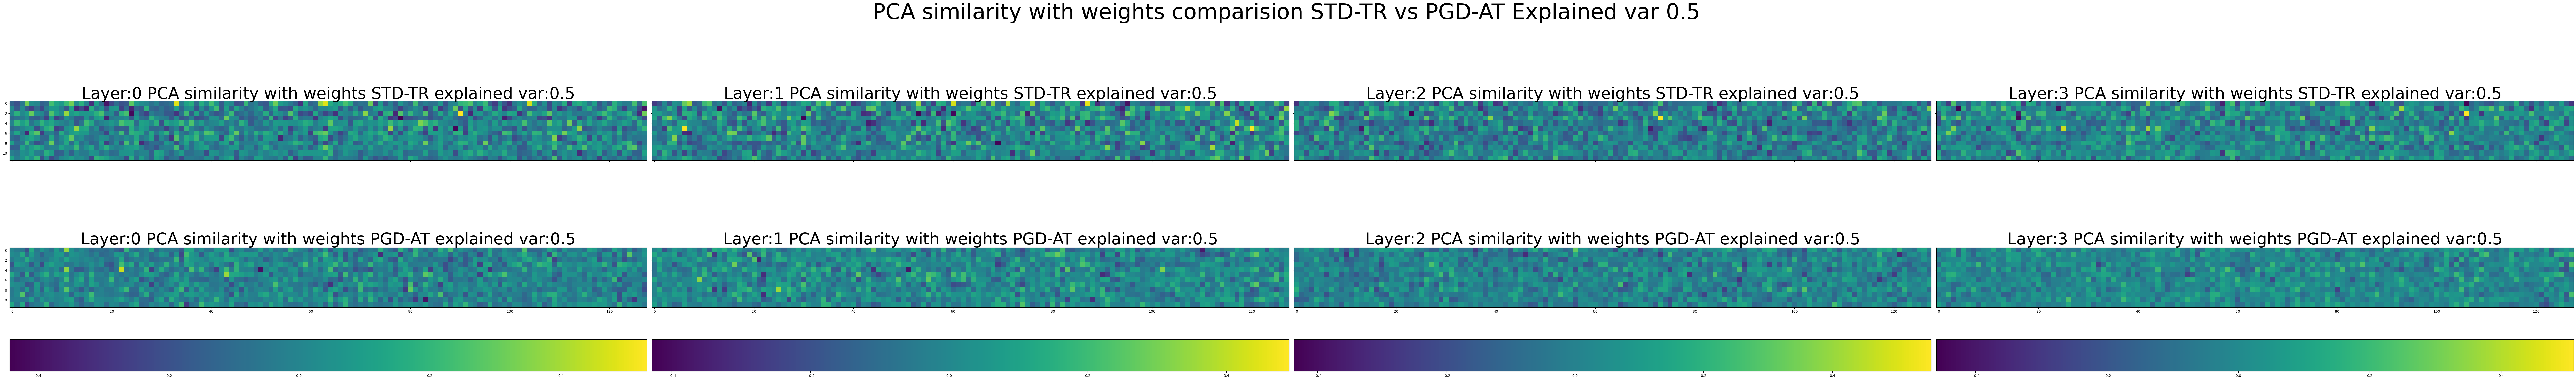

In [26]:
plot_pca_corr_matrix(std_pca_sim,pgd_pca_sim,std_path,pgdat_path,explained_var_required)

### Get the pre-activations as a whole tensor

In [32]:
# pgdat_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt"
pgdat_path = "root/model/save/mnist/adversarial_training/MT_fc_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt"
# pgd_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",pgdat_path,trainloader)
pgd_sf_preact = generate_preacts_all_examples("fc_dlgn",pgdat_path,trainloader)
pgd_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Gating net params: 150016
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
dummy_input  torch.Size([1, 1, 28, 28])
current_tensor_size  torch.Size([1, 784])
current_layer Linear(in_features=784, out_features=128, bias=True)
merged_conv_matrix:torch.Size([128, 784]) merged_c

Generating Distance from HP: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [33]:
# std_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir.pt"
std_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_dlgn_W_128_D_4_dir.pt"
# std_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",std_path,trainloader)
std_sf_preact = generate_preacts_all_examples("fc_dlgn",std_path,trainloader)
std_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Gating net params: 150016
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
dummy_input  torch.Size([1, 1, 28, 28])
current_tensor_size  torch.Size([1, 784])
current_layer Linear(in_features=784, out_features=128, bias=True)
merged_conv_matrix:torch.Size([128, 784]) merged_c

Generating Distance from HP:   0%|          | 0/469 [00:00<?, ?it/s]

Generating Distance from HP: 100%|██████████| 469/469 [00:16<00:00, 28.89it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [34]:
np.mean(np.min(np.abs(std_sf_preact),axis=1))

1.4626841e-05

In [35]:
np.mean(np.min(np.abs(pgd_sf_preact),axis=1))

0.008780439

In [36]:
np.sum(np.where(np.abs(std_sf_preact) > 0.3,1,0))/np.prod(std_sf_preact.shape)

0.6480457682291667

In [37]:
np.sum(np.where(np.abs(pgd_sf_preact) > 0.3,1,0))/np.prod(pgd_sf_preact.shape)

0.7024855794270833

In [38]:
# save_margin_as_csv(std_sf_preact,std_path)

In [39]:
# save_margin_as_csv(pgd_sf_preact,pgdat_path)

### Margin plots

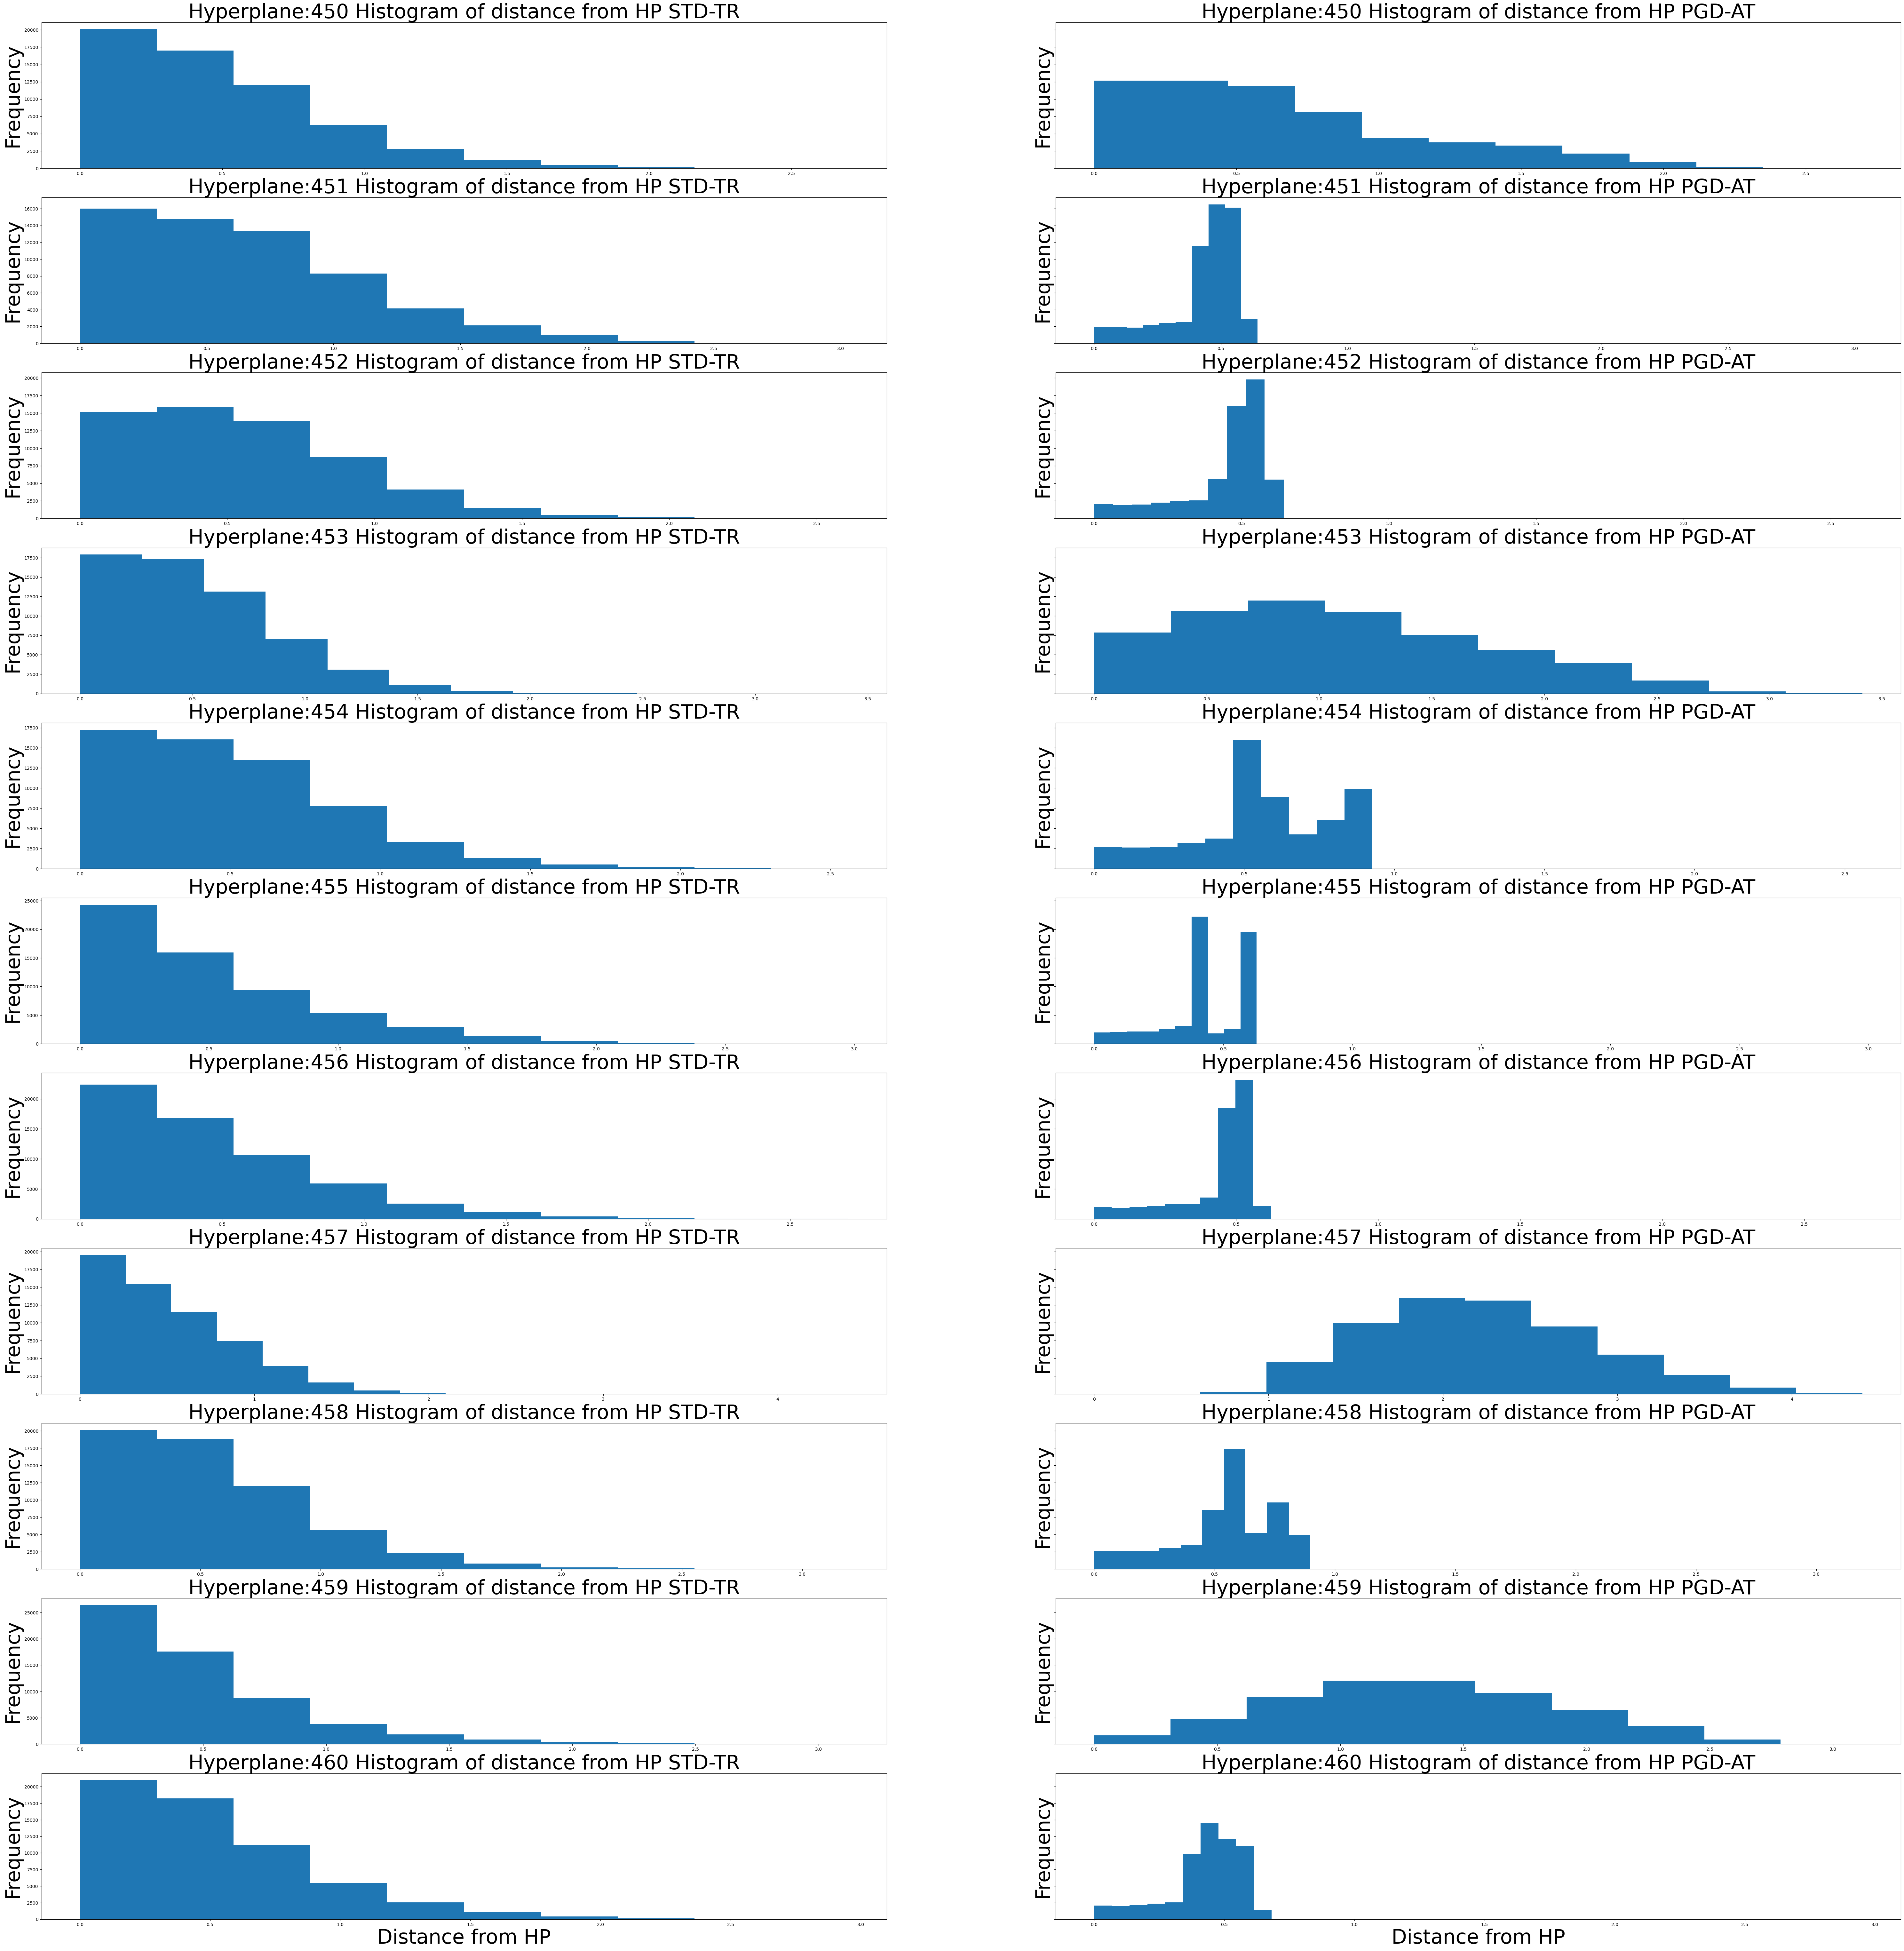

In [40]:
plot_margin_per_gate(std_sf_preact,pgd_sf_preact,std_path,pgdat_path,gateindx_start=450,gate_indx_end=450+10)

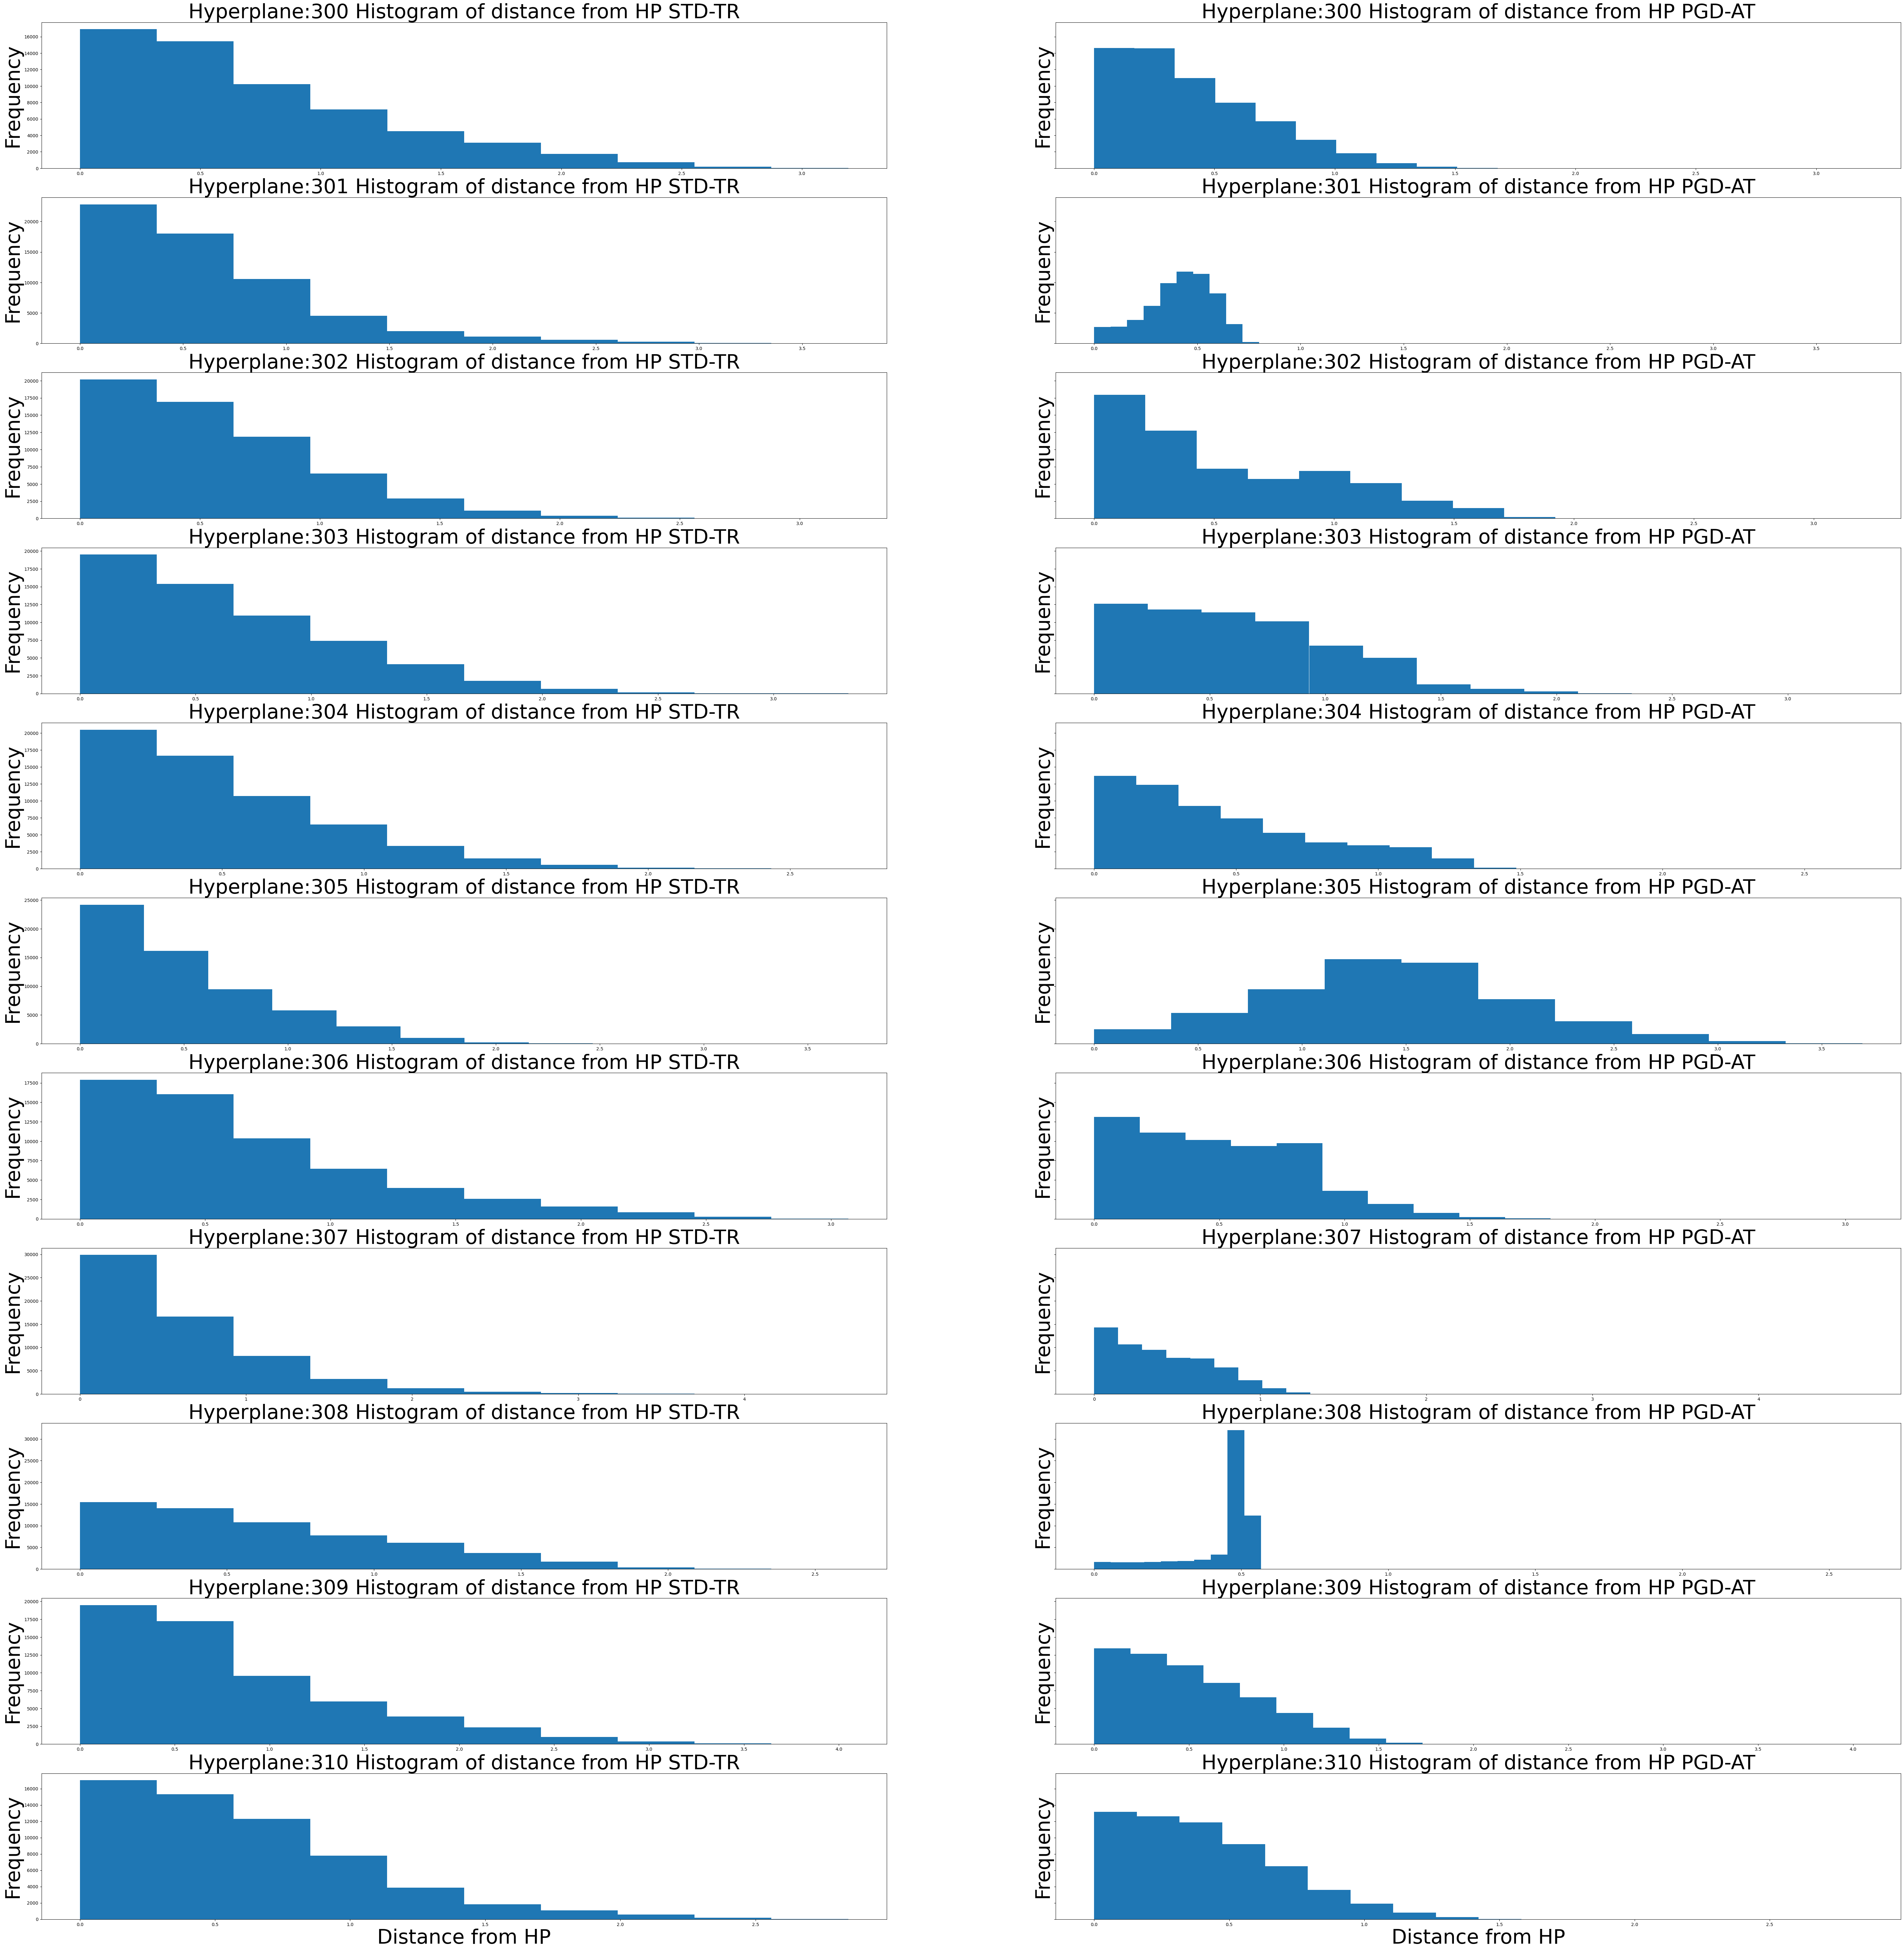

In [41]:
plot_margin_per_gate(std_sf_preact,pgd_sf_preact,std_path,pgdat_path,gateindx_start=300,gate_indx_end=300+10)

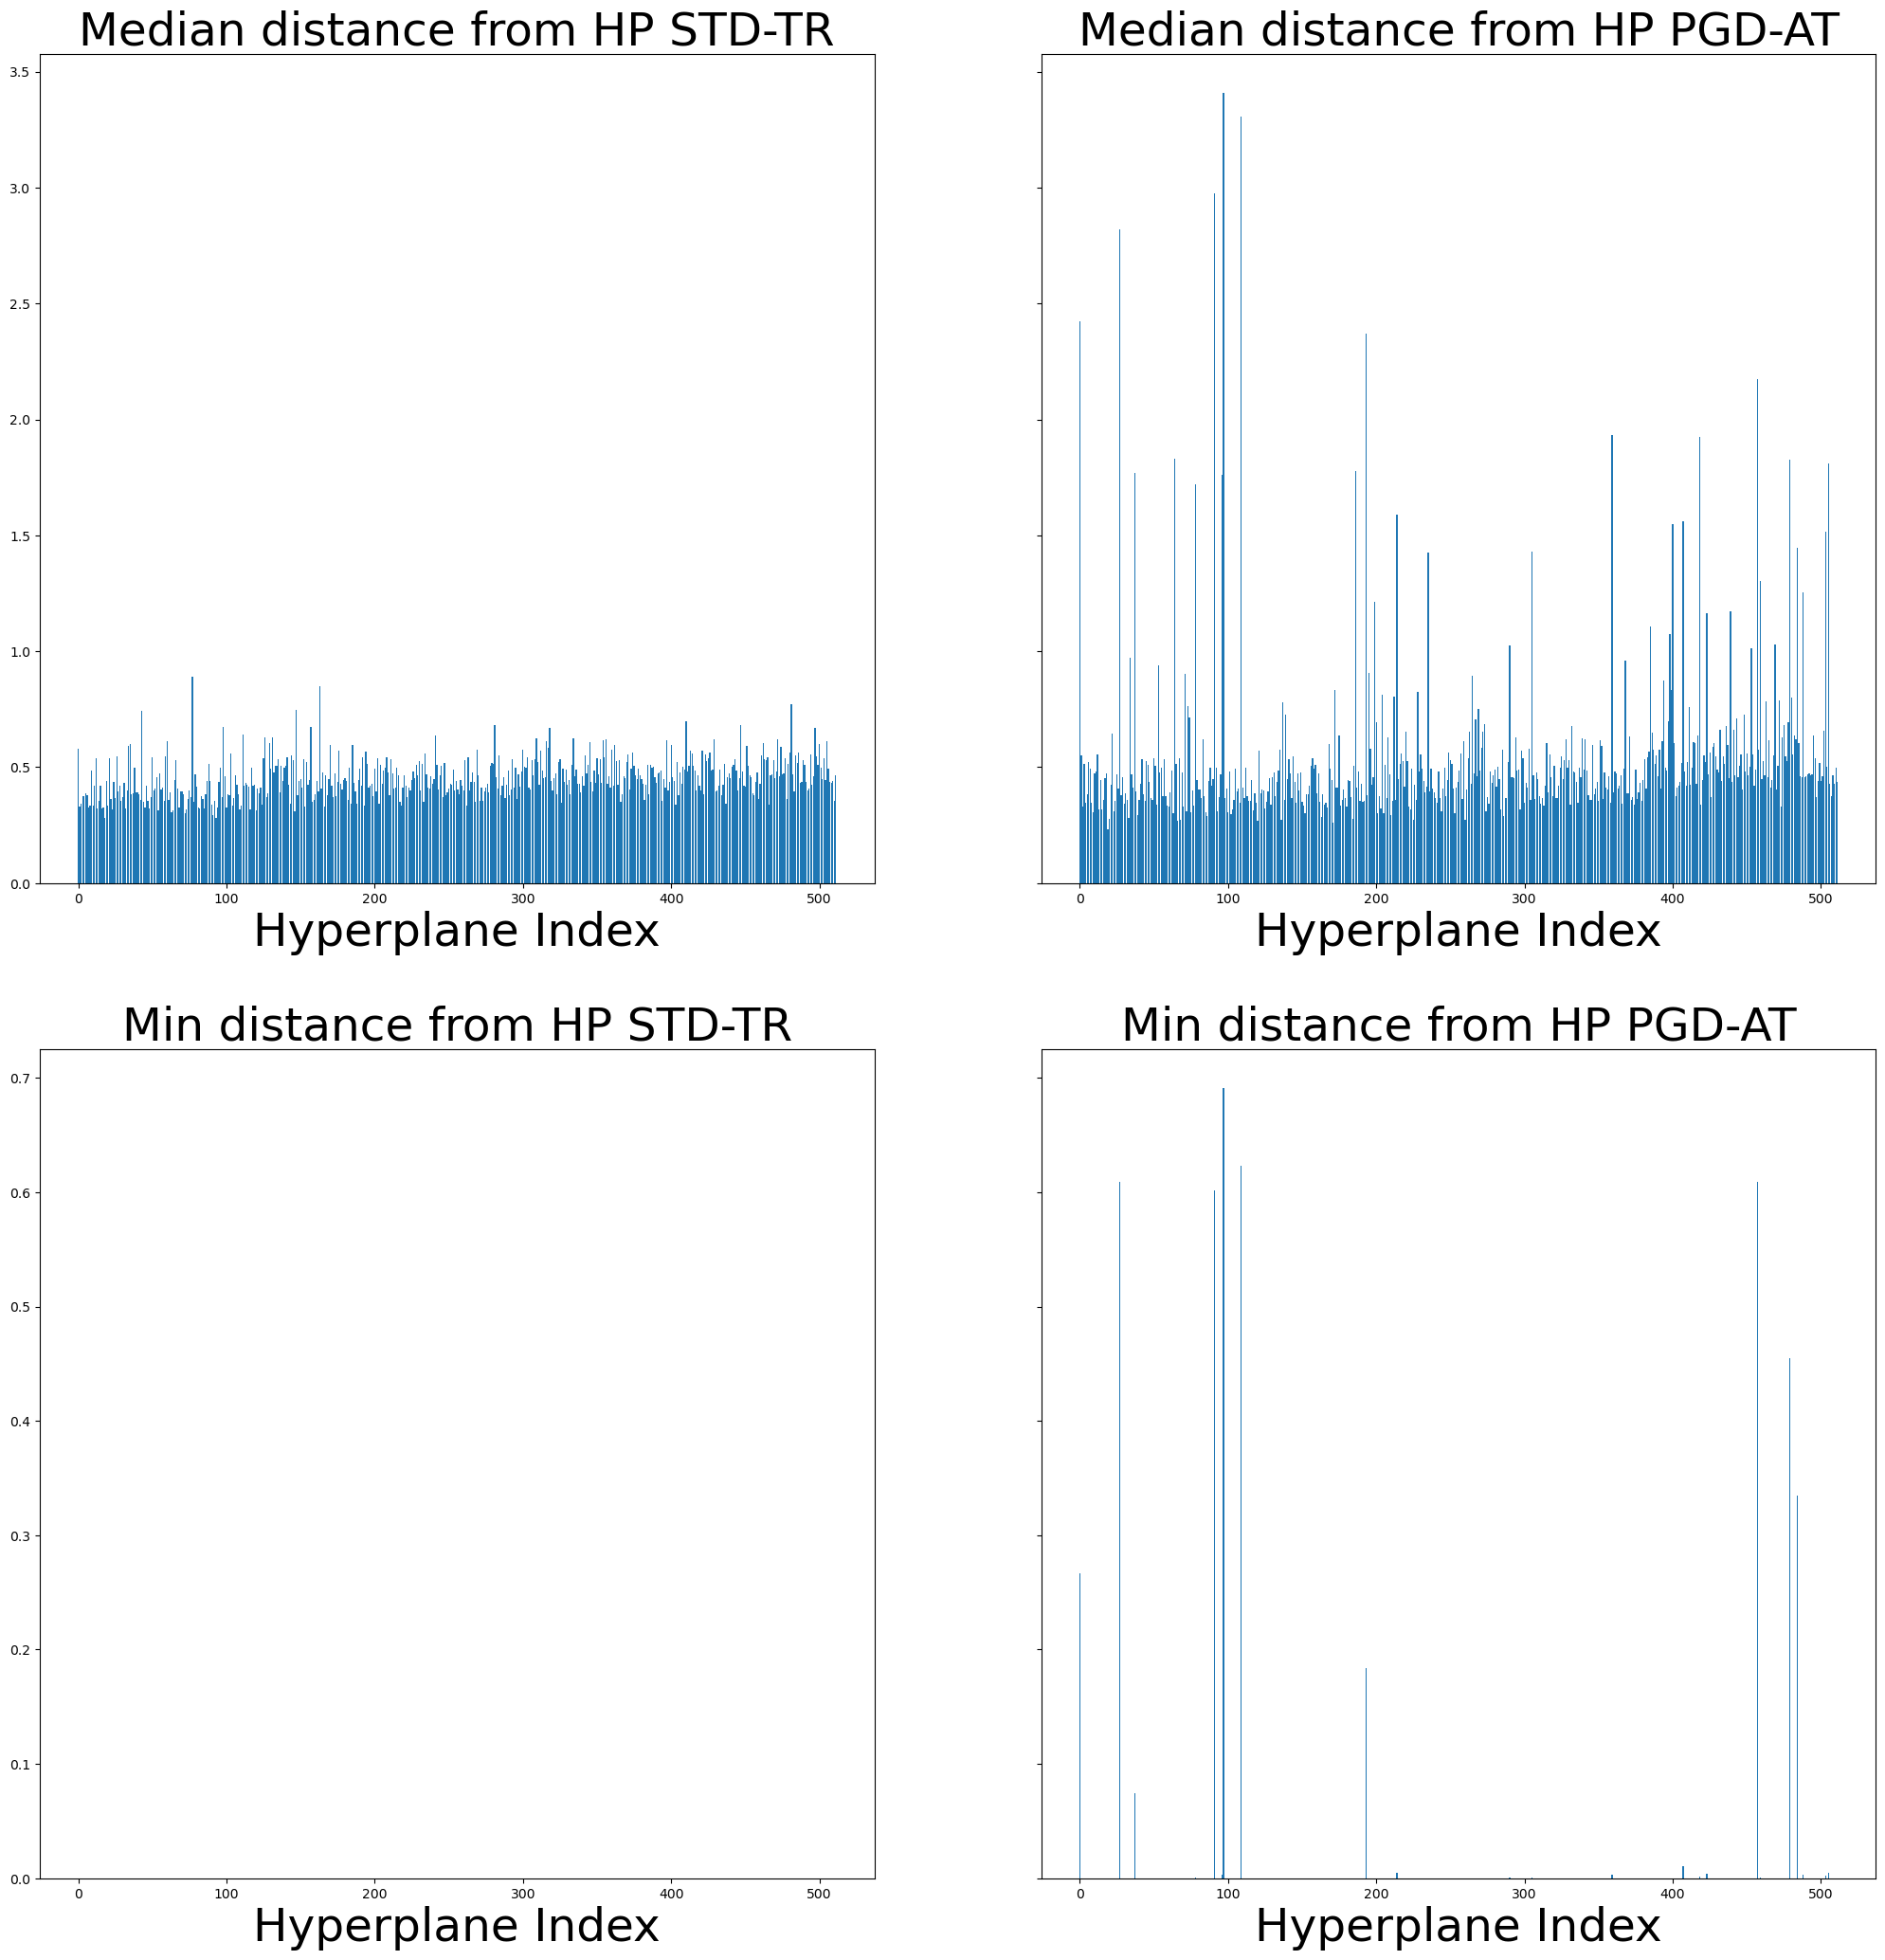

In [43]:
plot_margin_stats(std_sf_preact,pgd_sf_preact,std_path,pgdat_path)

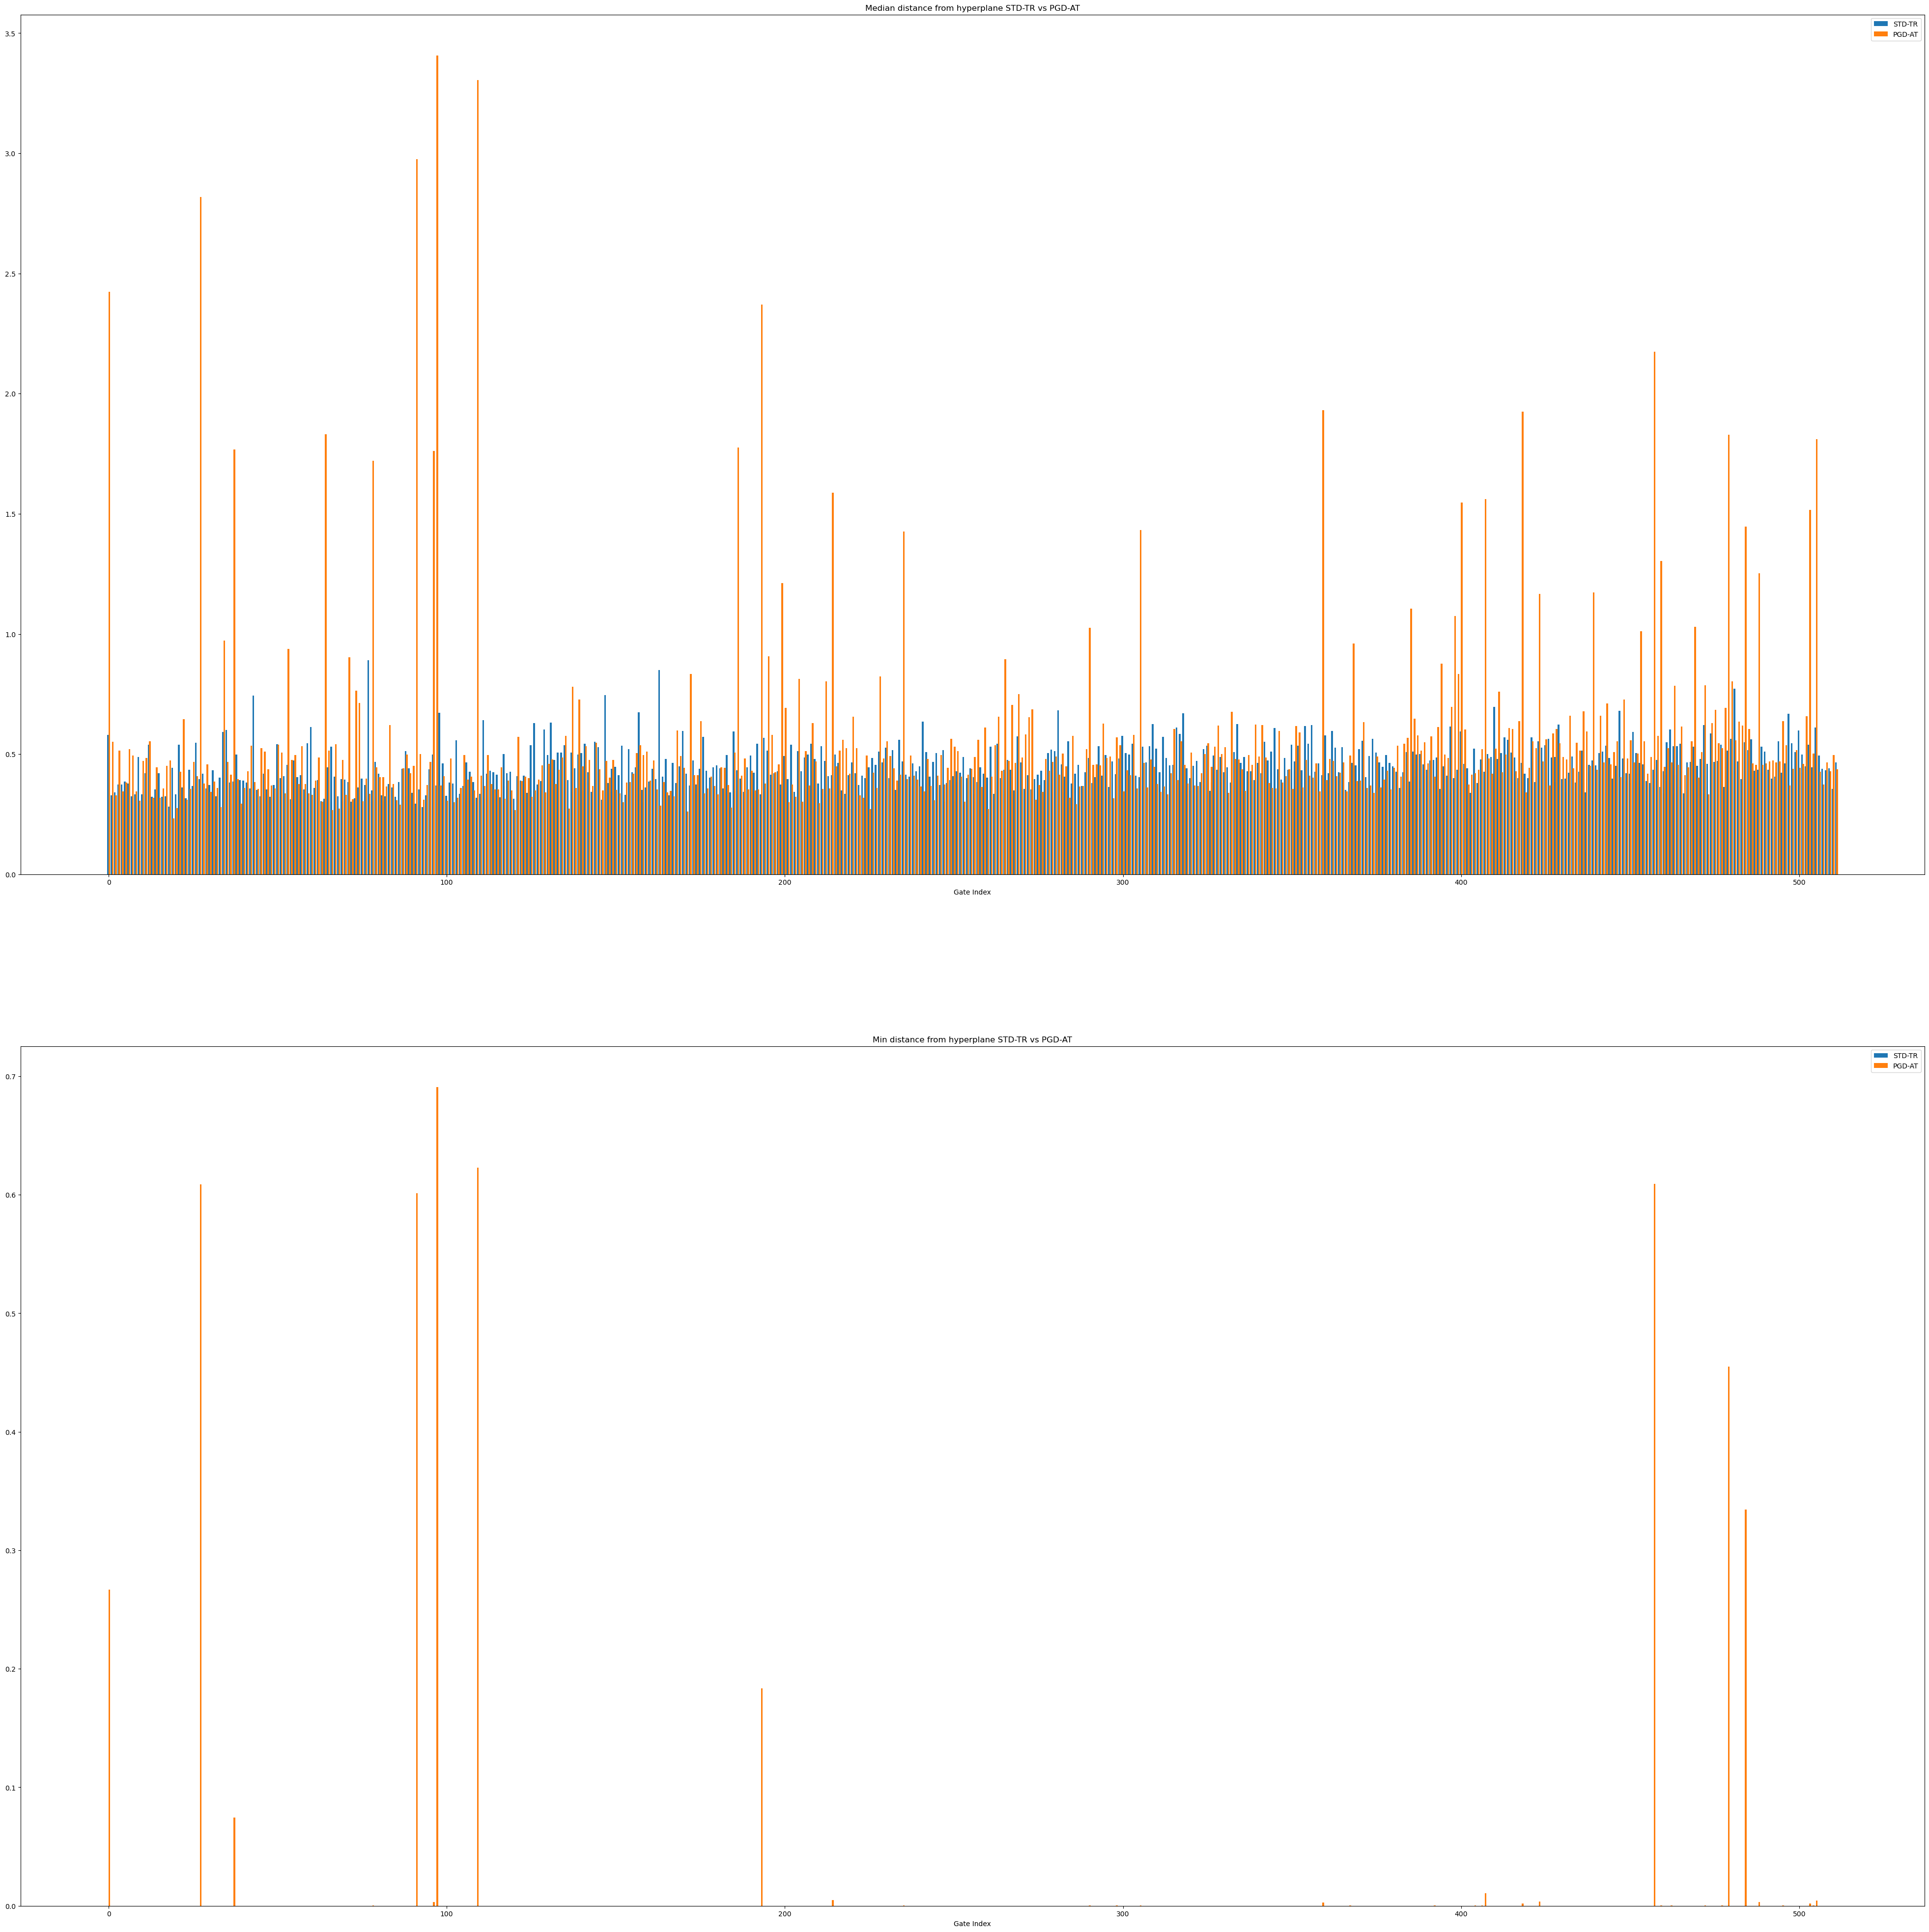

In [28]:
plot_margin_stats_together(std_sf_preact,pgd_sf_preact,std_path,pgdat_path)

### Getting the correlation between gate weights

In [18]:
# pgdat_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt"
pgdat_path = "root/model/save/mnist/adversarial_training/MT_fc_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt"
# pgd_sf_weight_corr = generate_weight_correlation("fc_sf_dlgn",pgdat_path)
pgd_sf_weight_corr,pgd_sf_full_weight_corr = generate_weight_correlation("fc_dlgn",pgdat_path,is_get_full_correlation=True)
pgd_sf_weight_corr[0].shape,pgd_sf_full_weight_corr.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Gating net params: 150016
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
dummy_input  torch.Size([1, 1, 28, 28])
current_tensor_size  torch.Size([1, 784])
current_layer Linear(in_features=784, out_features=128, bias=True)
merged_conv_matrix:torch.Size([128, 784]) merged_c

((128, 128), (512, 512))

In [26]:
# std_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir.pt"
std_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_dlgn_W_128_D_4_dir.pt"
# std_sf_weight_corr = generate_weight_correlation("fc_sf_dlgn",std_path)
std_sf_weight_corr,std_sf_full_weight_corr = generate_weight_correlation("fc_dlgn",std_path,is_get_full_correlation=True)
std_sf_weight_corr[0].shape,std_sf_full_weight_corr.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Gating net params: 150016
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
dummy_input  torch.Size([1, 1, 28, 28])
current_tensor_size  torch.Size([1, 784])
current_layer Linear(in_features=784, out_features=128, bias=True)
merged_conv_matrix:torch.Size([128, 784]) merged_c

((128, 128), (512, 512))

### Weight correlation plots

In [31]:
plot_full_weight_correlation(std_sf_full_weight_corr,pgd_sf_full_weight_corr,std_path,pgdat_path)

In [65]:
plot_weight_correlation(std_sf_weight_corr,pgd_sf_weight_corr,std_path,pgdat_path)

### SVM comparision

In [28]:
data_config = DatasetConfig(
                'mnist', is_normalize_data=True, valid_split_size=0.1, batch_size=128, list_of_classes=None,custom_dataset_path=None)
filtered_X_train, _, X_valid, _, filtered_X_test, _ = preprocess_dataset_get_dataset(
            data_config, "fc_sf_dlgn", verbose=0, dataset_folder="./Datasets/", is_split_validation=False)
filtered_X_train = np.reshape(filtered_X_train,(60000,784))
filtered_X_train.shape

np.max(filtered_X_train) 255.0


(60000, 784)

In [40]:
def generate_and_save_svm_gate_weight_sf_dlgn(dest_suffix,svm_pickle_path,src_ref_model_path):
    all_svms = []
    with open(svm_pickle_path, "rb") as f:
        while True:
            try:
                all_svms.append(pickle.load(f))
            except EOFError:
                break
    pgd_sf_model = torch.load(src_ref_model_path)
    pgd_sf_model = pgd_sf_model.to(device)
    pgd_sf_model.eval()

    cfind = 0
    svm_weight_resized=[]
    svm_bias_resized=[]
    for layer_name, layer_obj in pgd_sf_model.get_gate_layers_ordered_dict().items():
        cur_lay_width = layer_obj.weight.shape
        # print("cur_lay_width ",list(cur_lay_width))
        cur_lay_svm_weight = None
        cur_lay_svm_bias = None
        while(cur_lay_svm_weight is None or list(cur_lay_svm_weight.shape) != list(cur_lay_width)):
            if(cur_lay_svm_weight is None):
                cur_lay_svm_weight = all_svms[cfind].coef_
                cur_lay_svm_bias = all_svms[cfind].intercept_
            else:
                cur_lay_svm_weight = np.vstack((cur_lay_svm_weight,all_svms[cfind].coef_))
                cur_lay_svm_bias = np.vstack((cur_lay_svm_bias,all_svms[cfind].intercept_))
            # print("cfind:{} cur_lay_svm_weight:{} cur_lay_svm_bias:{}".format(cfind,cur_lay_svm_weight.shape,cur_lay_svm_bias.shape))
            cfind+=1
        svm_weight_resized.append(cur_lay_svm_weight)
        svm_bias_resized.append(cur_lay_svm_bias)
    
    pgd_sf_svm_gates_model = torch.load(src_ref_model_path)
    with torch.no_grad():
        for i in range(len(pgd_sf_svm_gates_model.gating_network.list_of_modules)):
            pgd_sf_svm_gates_model.gating_network.list_of_modules[i].weight = torch.nn.Parameter(torch.from_numpy(svm_weight_resized[i]))
            pgd_sf_svm_gates_model.gating_network.list_of_modules[i].bias = torch.nn.Parameter(torch.squeeze(torch.from_numpy(svm_bias_resized[i])))
    if not os.path.exists(get_margin_folder(src_ref_model_path)):
        os.makedirs(get_margin_folder(src_ref_model_path))
    torch.save(pgd_sf_svm_gates_model,get_margin_folder(src_ref_model_path)+"/"+dest_suffix)
    

In [45]:
generate_and_save_svm_gate_weight_sf_dlgn("svm_gated_C_0.00000001_sf_dlgn.pt","root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir/MARGIN_ANALYSIS/all_svm_models_C_0.0000000001.pckl","root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt")

In [16]:
svm_gate_model_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s] 

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [17]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.731519140625, 3.978002e-05)

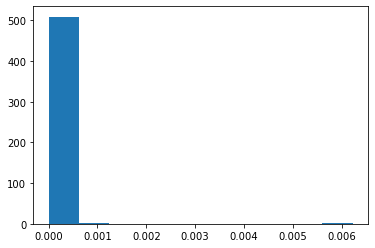

: 

In [18]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [39]:
svm_gate_model_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:40<00:00, 11.52it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [40]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.8540430989583333, 0.0016619423)

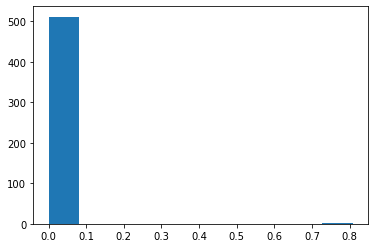

: 

In [41]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [15]:
svm_gate_model_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir/MARGIN_ANALYSIS/svm_gated_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:42<00:00, 11.17it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [16]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.8518667643229166, 0.0070019695)

In [17]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [18]:
svm_gate_model_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir/MARGIN_ANALYSIS/svm_gated_C_1_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:33<00:00, 14.02it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [19]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.8515637369791667, 0.005748925)

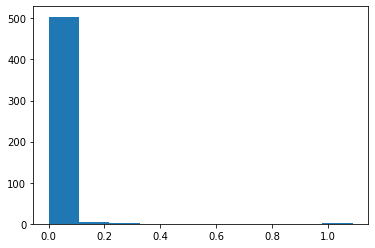

In [20]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [21]:
svm_gate_model_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir/MARGIN_ANALYSIS/svm_gated_C_0.1_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:36<00:00, 12.72it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [22]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.85767138671875, 0.0011963247)

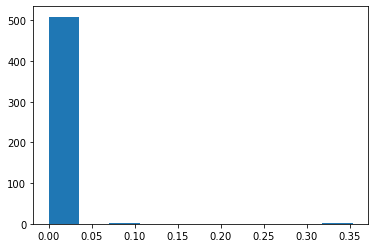

In [23]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [24]:
svm_gate_model_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir/MARGIN_ANALYSIS/svm_gated_C_0.01_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [25]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.8712476236979166, 0.0048660645)

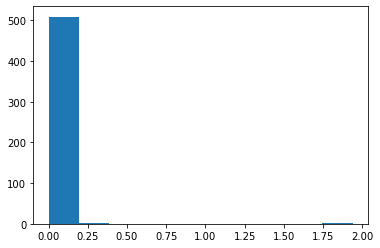

In [26]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [27]:
svm_gate_model_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir/MARGIN_ANALYSIS/svm_gated_C_0.0001_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:35<00:00, 13.33it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [28]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.9226619140625, 0.051528715)

In [29]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [30]:
svm_gate_model_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir/MARGIN_ANALYSIS/svm_gated_C_0.00001_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:30<00:00, 15.59it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [31]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.9504526041666667, 0.18929234)

In [32]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [33]:
svm_gate_model_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir/MARGIN_ANALYSIS/svm_gated_C_0.000001_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:30<00:00, 15.48it/s]


overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [34]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.9750707682291667, 0.6874633)

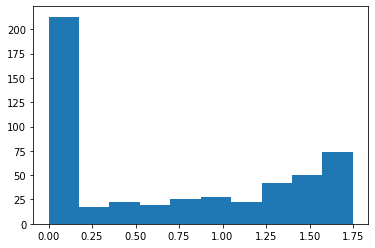

In [35]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [36]:
svm_gate_model_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir/MARGIN_ANALYSIS/svm_gated_C_0.0000001_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:39<00:00, 11.80it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [37]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.9882515950520834, 1.1042303)

In [38]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [18]:
svm_gate_model_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir/MARGIN_ANALYSIS/svm_gated_C_0.00000001_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s] 

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [19]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.9910414388020833, 1.1784003)

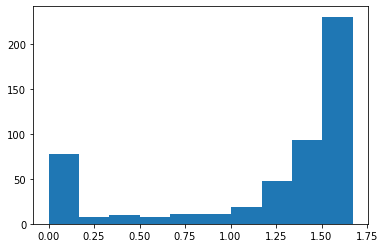

In [20]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [ ]:
svm_gate_model_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

In [9]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.731519140625, 3.978002e-05)

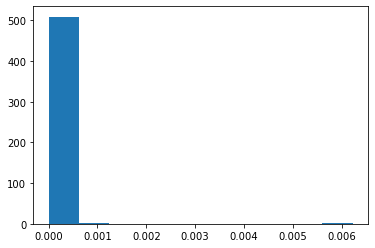

In [10]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [ ]:
svm_gate_model_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir/MARGIN_ANALYSIS/svm_gated_C_0.01_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

In [21]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.80825400390625, 0.001139467)

In [22]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [ ]:
svm_gate_model_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir/MARGIN_ANALYSIS/svm_gated_C_0.001_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

In [24]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.8465483723958334, 0.014357703)

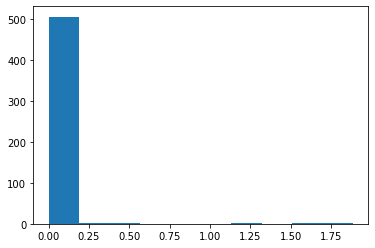

In [25]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [ ]:
svm_gate_model_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir/MARGIN_ANALYSIS/svm_gated_C_0.0001_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

In [27]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.88578935546875, 0.025862623)

In [28]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [ ]:
svm_gate_model_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir/MARGIN_ANALYSIS/svm_gated_C_0.00001_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

In [29]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.9232463541666667, 0.08452152)

In [30]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

In [35]:
svm_gate_model_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir/MARGIN_ANALYSIS/svm_gated_C_0.000001_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:42<00:00, 10.93it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [36]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.9628186197916667, 0.3855124)

In [37]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()

: 

In [31]:
svm_gate_model_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir/MARGIN_ANALYSIS/svm_gated_C_0.0000001_sf_dlgn.pt"
svm_gate_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",svm_gate_model_path,trainloader)
svm_gate_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Distance from HP: 100%|██████████| 469/469 [00:35<00:00, 13.30it/s]

overall_distance_from_HP  torch.Size([512, 60000])


(512, 60000)

In [32]:
np.sum(np.where(np.abs(svm_gate_sf_preact) > 0.3,1,0))/np.prod(svm_gate_sf_preact.shape),np.mean(np.min(np.abs(svm_gate_sf_preact),axis=1))

(0.9864480143229166, 0.8819393)

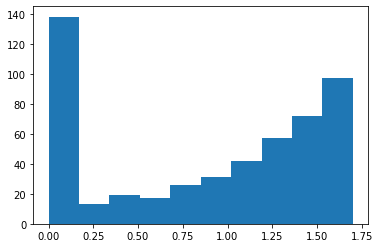

In [33]:
plt.hist(np.min(np.abs(svm_gate_sf_preact),axis=1))
plt.show()